
                    BEM TRIANGLE INTEGRATION TUTORIAL

EXAMPLE 1: Reference Triangle

The reference triangle is defined in (ξ, η) coordinates:
  • Vertex 0: (ξ, η) = (0, 0)
  • Vertex 1: (ξ, η) = (1, 0)
  • Vertex 2: (ξ, η) = (0, 1)

Constraint: ξ ≥ 0, η ≥ 0, ξ + η ≤ 1




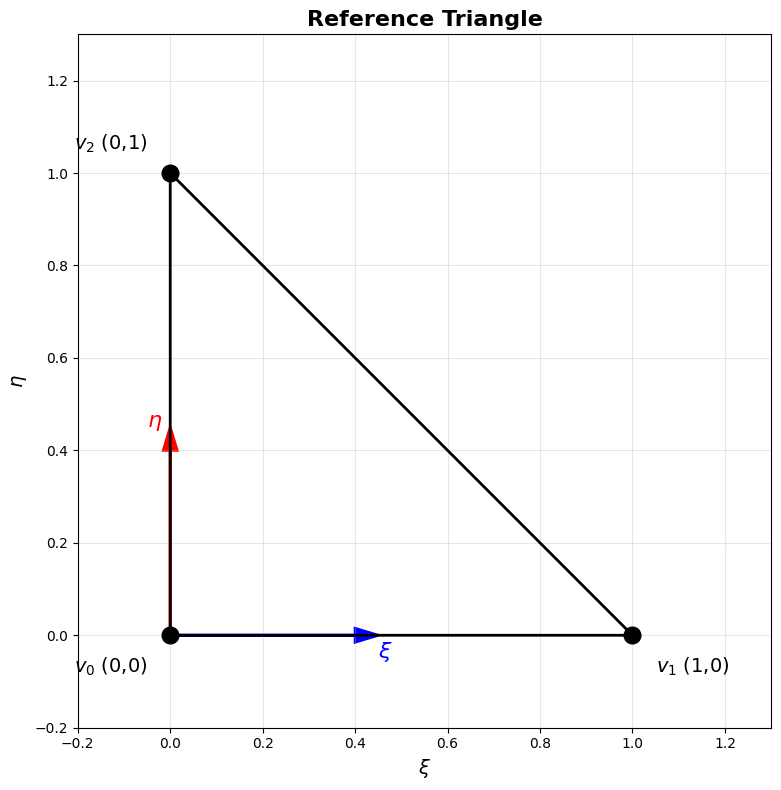

EXAMPLE 2: Linear (P1) Shape Functions

Linear shape functions for triangular elements:
  • N₀(ξ, η) = 1 - ξ - η  (equals 1 at vertex 0, 0 at other vertices)
  • N₁(ξ, η) = ξ          (equals 1 at vertex 1, 0 at other vertices)
  • N₂(ξ, η) = η          (equals 1 at vertex 2, 0 at other vertices)

Key property: N₀ + N₁ + N₂ = 1 (partition of unity)

These functions interpolate nodal values:
  φ(ξ, η) = N₀(ξ, η)φ₀ + N₁(ξ, η)φ₁ + N₂(ξ, η)φ₂




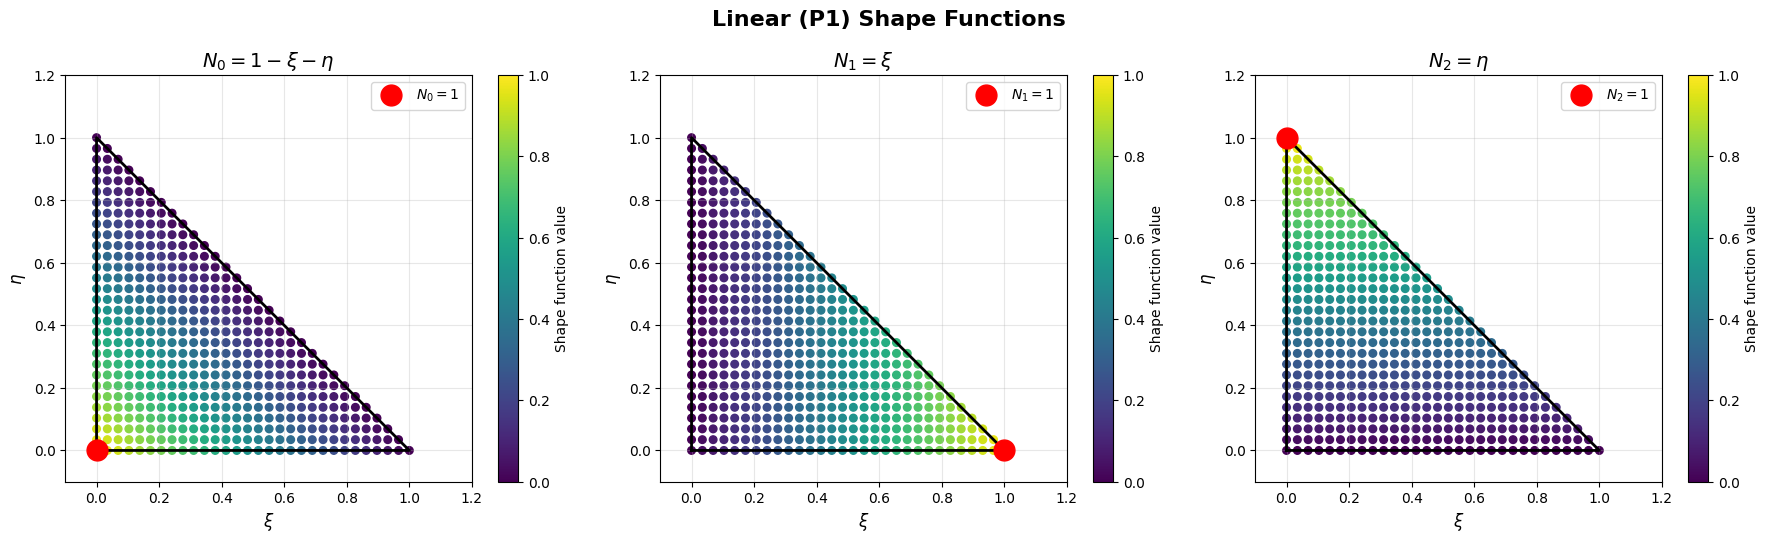

EXAMPLE 3: Physical Triangle in 3D

Physical triangle vertices:
  v₀ = [0. 0. 0.]
  v₁ = [1.5 0.2 0.1]
  v₂ = [0.3 1.2 0.2]

Geometric properties:
  Area: 0.8813
  Characteristic length h: 1.5652
  Normal vector: [-0.04538646 -0.15317932  0.98715559]
  Centroid: [0.6        0.46666667 0.1       ]




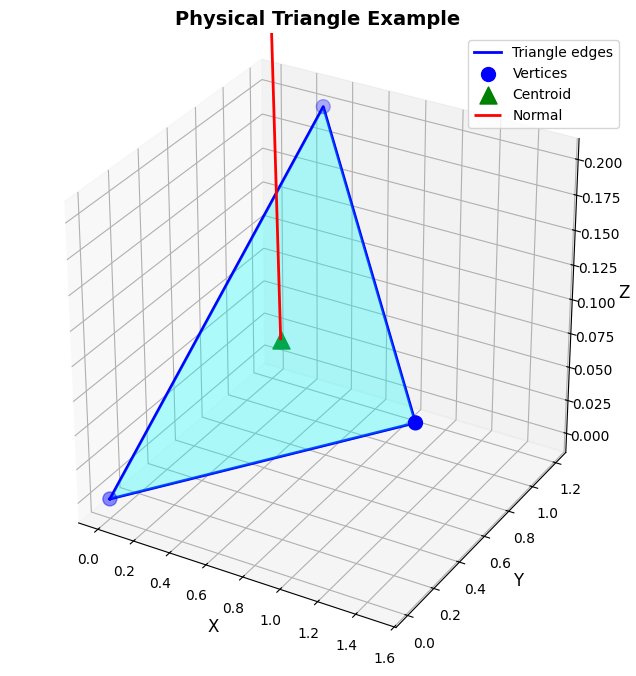

EXAMPLE 4: Quadrature Rule Comparison

Standard Gauss quadrature:
  • Order 1: 1 point at centroid (exact for constant functions)
  • Order 3: 3 points (exact for linear functions)
  • Order 7: 7 points (exact for quadratic functions)

Duffy transformation (singular integration):
  • Transforms unit square to triangle
  • Clusters points near singular vertex
  • Weights include Jacobian: J = u (u = radial coordinate)
  • Used when collocation point coincides with a vertex




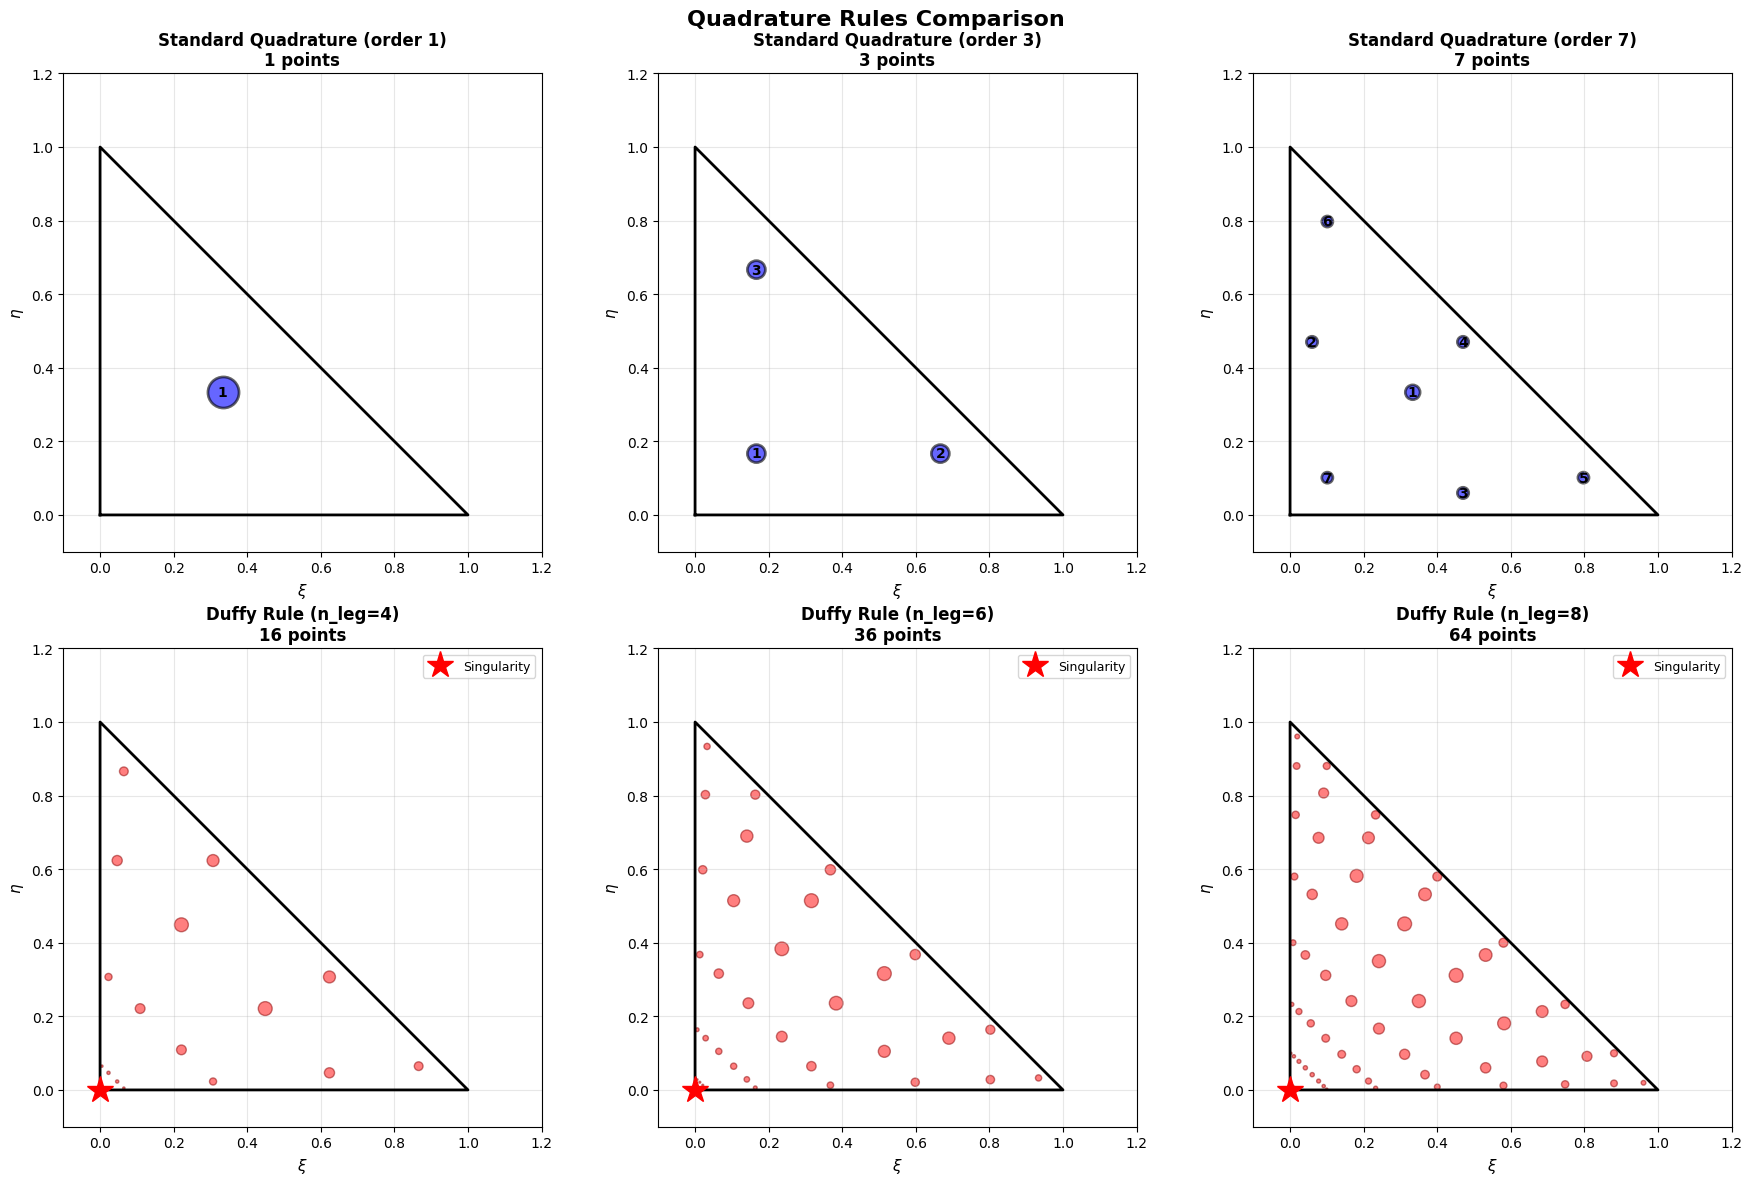

EXAMPLE 5: Collocation Point Scenarios

Singular (on vertex):
  Collocation point = vertex → SINGULAR

Near (close to element):
  Collocation point close to element → NEAR-SINGULAR

Regular (far from element):
  Collocation point far from element → REGULAR




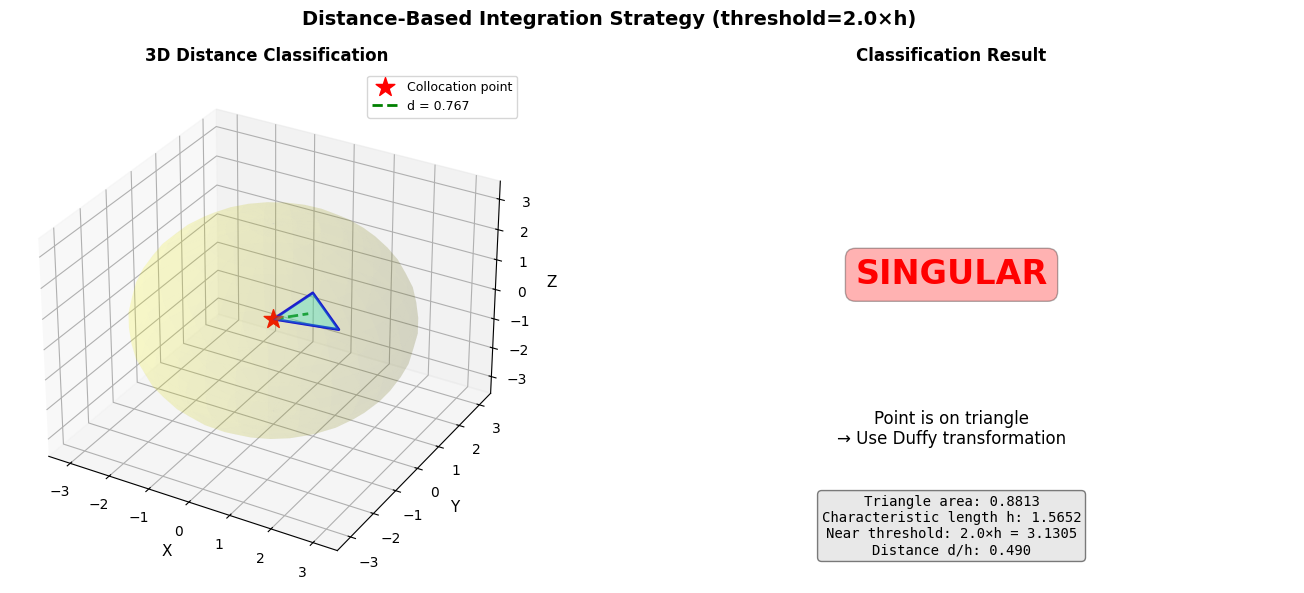

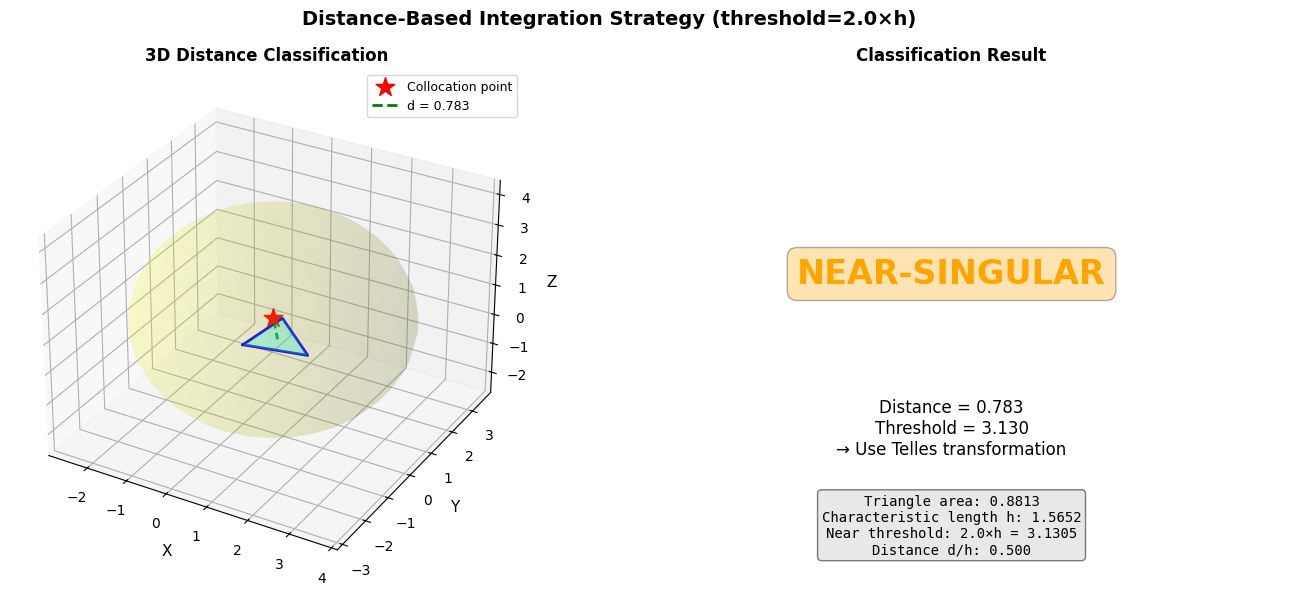

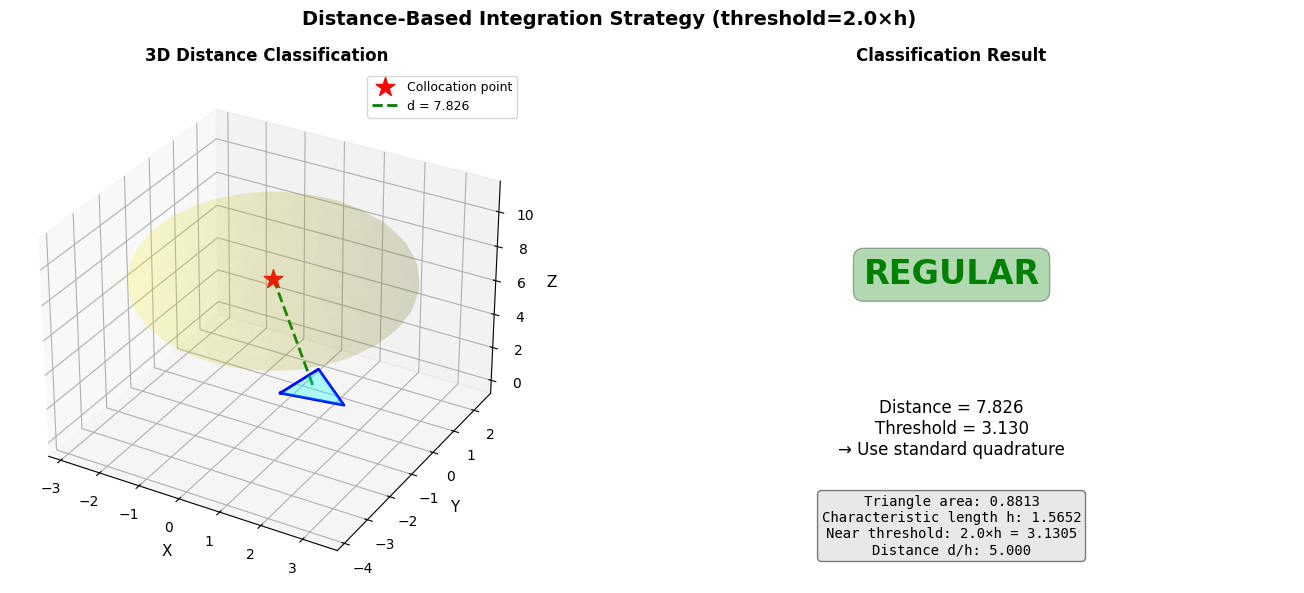

EXAMPLE 6: Telles Transformation

When collocation point is near (but not on) the element:
  • Standard quadrature may be inaccurate
  • Telles transformation clusters points near the projection
  • Uses cubic polynomial mapping with zero Jacobian at singularity

Transformation: t(s) = as³ + bs² + cs
  • Maps [0,1] → [0,1]
  • dt/ds = 0 at s₀ (reference point near singularity)
  • Increases quadrature density where integrand is large




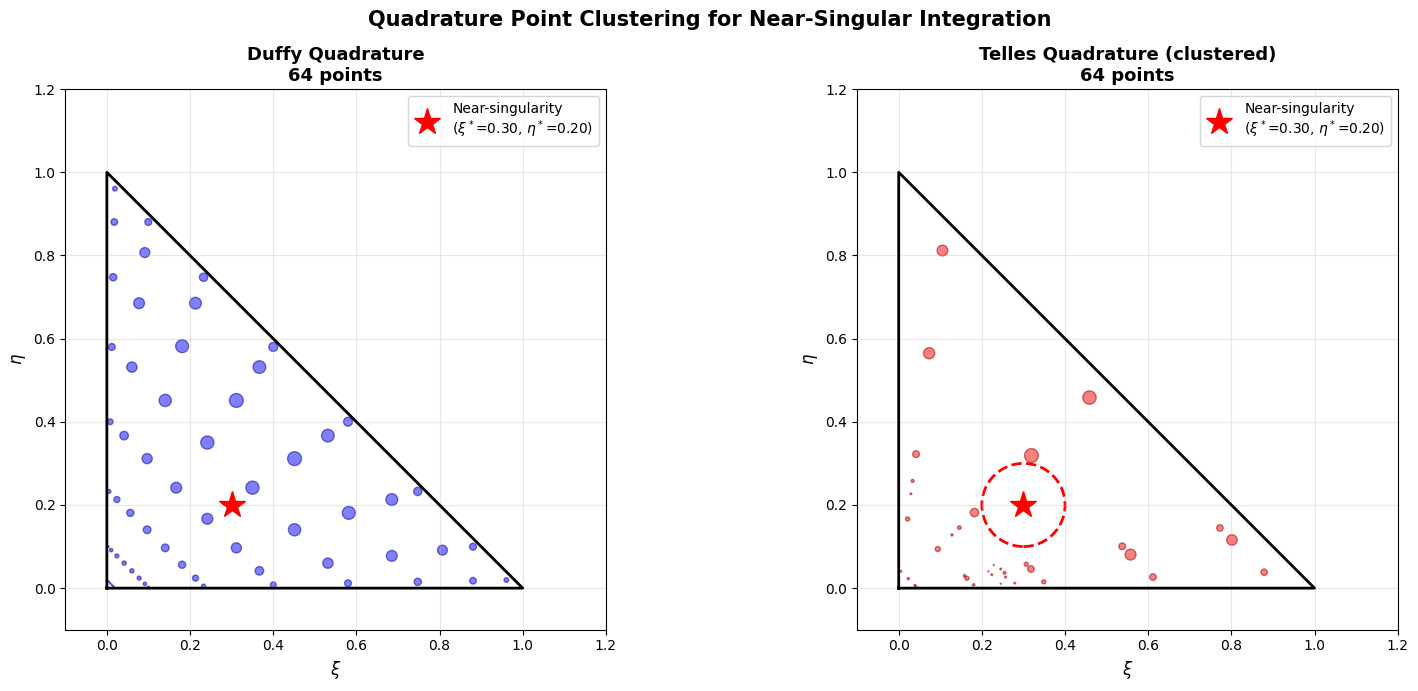

EXAMPLE 7: Complete Integration Workflow

For each collocation point x_i:

1. CLASSIFY all source elements relative to x_i:
     for each element j:
       d = ||centroid_j - x_i||
       if x_i on element_j → SINGULAR
       elif d < threshold × h_j → NEAR-SINGULAR
       else → REGULAR

2. SELECT integration strategy:
     SINGULAR → Duffy transformation
     NEAR-SINGULAR → Telles transformation
     REGULAR → Standard Gauss quadrature

3. COMPUTE element contributions:
     For each element, compute:
       ∫_element G(x_i, y) N_j(y) dS_y  (single layer)
       ∫_element ∂G/∂n_y(x_i, y) N_j(y) dS_y  (double layer)
       etc.

4. ASSEMBLE into global matrix:
     A[i, nodes_of_element_j] += element_contribution




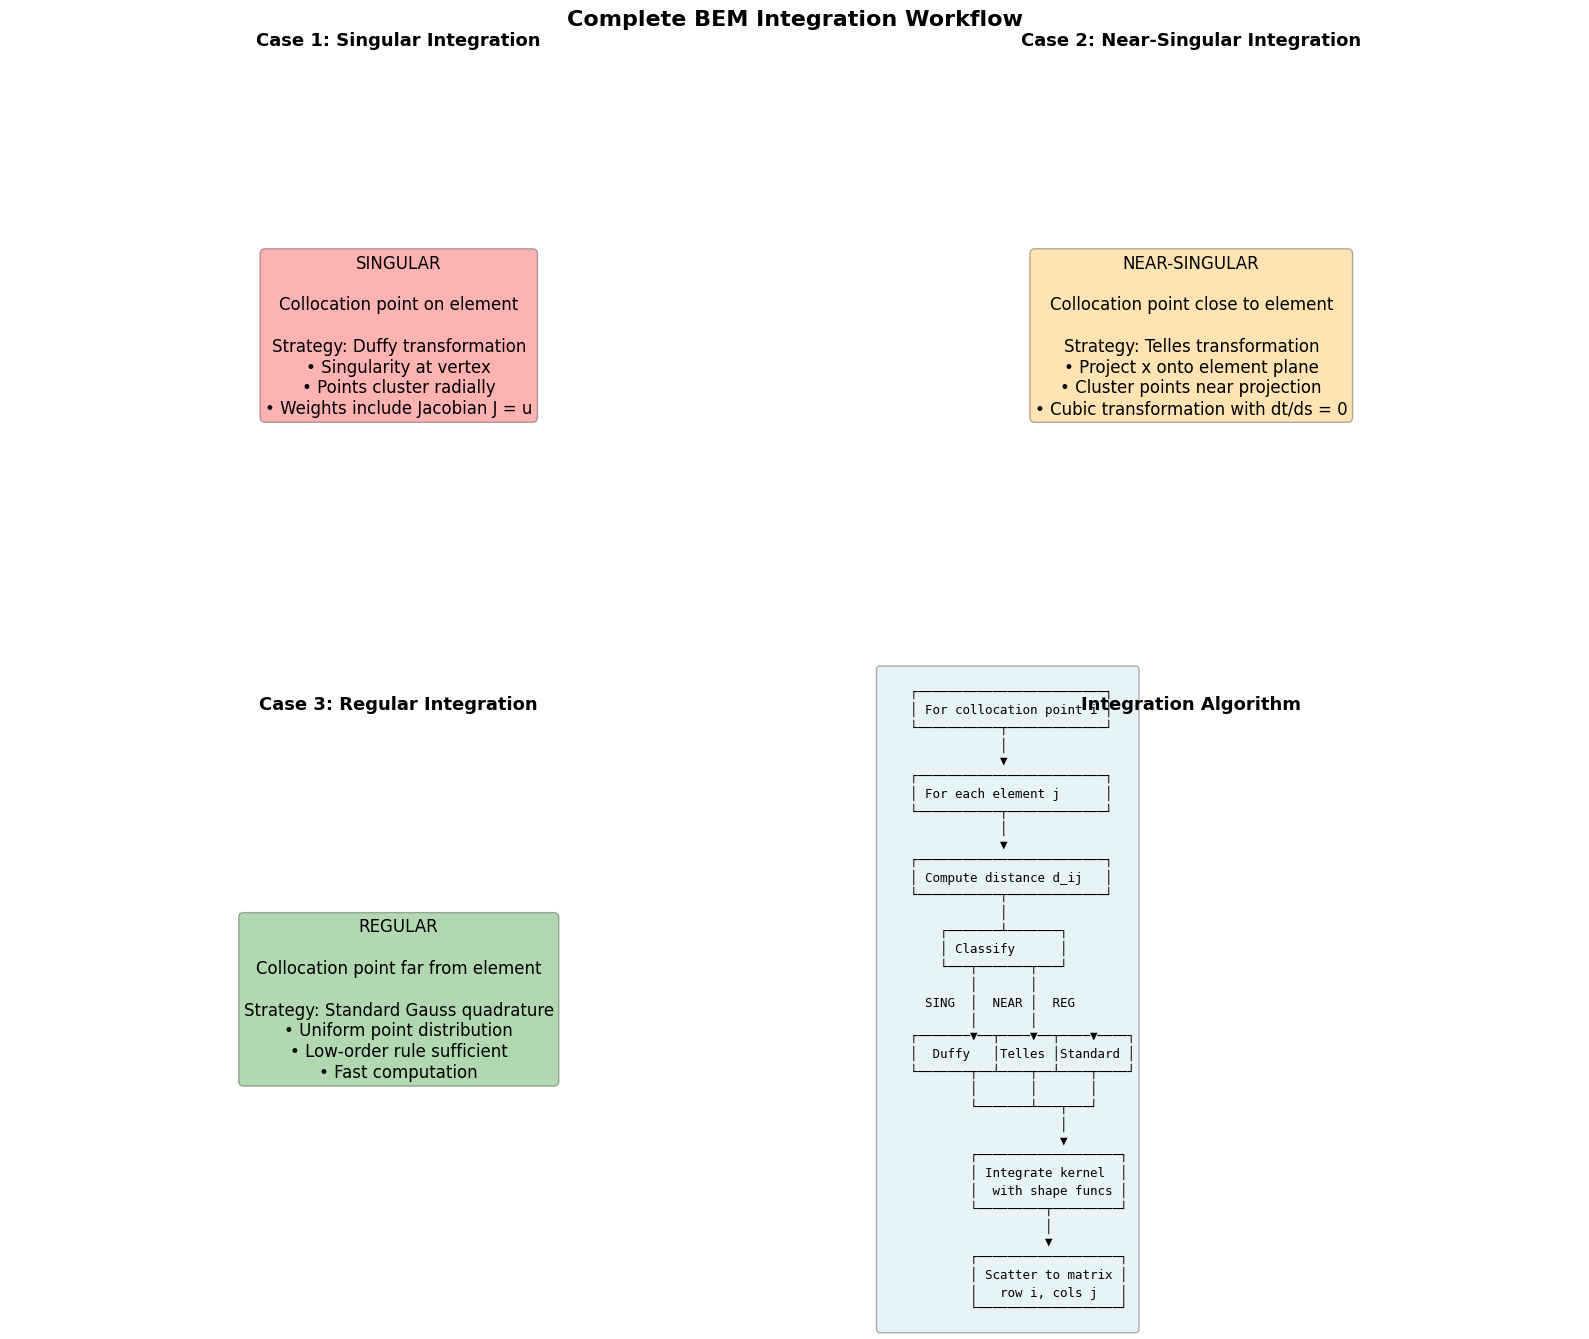


Tutorial complete! Key takeaways:

1. Linear elements use P1 shape functions (N₀, N₁, N₂)
2. Integration strategy depends on collocation point distance
3. Singular: Use Duffy transformation (point on element)
4. Near-singular: Use Telles transformation (point close to element)
5. Regular: Use standard Gauss quadrature (point far from element)
6. Proper classification and quadrature choice ensures accuracy




In [1]:
"""
Interactive Visualization of BEM Integration on Linear Triangular Elements

This notebook explores integration strategies for boundary element methods
on a single triangular element with linear (P1) shape functions.

Topics covered:
1. Reference and physical triangles
2. P1 shape functions
3. Collocation point placement
4. Singular, near-singular, and regular integration scenarios
5. Quadrature point distributions (standard, Duffy, Telles)
6. Distance-based classification
"""

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

#%% ============================================================================
# SECTION 1: DEFINE TRIANGLE AND SHAPE FUNCTIONS
# ==============================================================================

class Triangle:
    """Single triangular element for BEM visualization."""
    
    def __init__(self, v0, v1, v2):
        """
        Initialize triangle with three vertices.
        
        Args:
            v0, v1, v2: Vertices as (3,) arrays
        """
        self.v0 = np.array(v0)
        self.v1 = np.array(v1)
        self.v2 = np.array(v2)
        
        # Edge vectors
        self.e1 = self.v1 - self.v0
        self.e2 = self.v2 - self.v0
        
        # Normal vector
        cross = np.cross(self.e1, self.e2)
        self.area = 0.5 * np.linalg.norm(cross)
        self.normal = cross / (np.linalg.norm(cross) + 1e-16)
        
        # Centroid
        self.centroid = (self.v0 + self.v1 + self.v2) / 3.0
        
        # Characteristic length
        self.h = max(
            np.linalg.norm(self.e1),
            np.linalg.norm(self.e2),
            np.linalg.norm(self.v2 - self.v1)
        )
    
    def map_to_physical(self, xi_eta):
        """
        Map reference coordinates (xi, eta) to physical coordinates.
        
        Args:
            xi_eta: (N, 2) array of reference coordinates
            
        Returns:
            (N, 3) array of physical coordinates
        """
        xi = xi_eta[:, 0:1]
        eta = xi_eta[:, 1:2]
        return self.v0 + xi * self.e1 + eta * self.e2
    
    def shape_functions(self, xi_eta):
        """
        Evaluate P1 shape functions at reference coordinates.
        
        Args:
            xi_eta: (N, 2) array
            
        Returns:
            (N, 3) array where columns are N0, N1, N2
        """
        N = np.zeros((xi_eta.shape[0], 3))
        N[:, 1] = xi_eta[:, 0]  # N1 = xi
        N[:, 2] = xi_eta[:, 1]  # N2 = eta
        N[:, 0] = 1 - N[:, 1] - N[:, 2]  # N0 = 1 - xi - eta
        return N


def reference_triangle_grid(n=50):
    """Create a grid of points in reference triangle."""
    xi = np.linspace(0, 1, n)
    eta = np.linspace(0, 1, n)
    XI, ETA = np.meshgrid(xi, eta)
    
    # Keep only points inside triangle
    mask = (XI + ETA) <= 1.0
    xi_flat = XI[mask]
    eta_flat = ETA[mask]
    
    return np.column_stack([xi_flat, eta_flat])


#%% ============================================================================
# SECTION 2: QUADRATURE RULES
# ==============================================================================

def standard_quad(order=3):
    """Standard Gauss quadrature on reference triangle."""
    if order == 1:
        pts = np.array([[1/3, 1/3]])
        w = np.array([0.5])
    elif order == 3:
        pts = np.array([[1/6, 1/6],
                       [2/3, 1/6],
                       [1/6, 2/3]])
        w = np.array([1/6, 1/6, 1/6])
    elif order == 7:
        pts = np.array([[1/3, 1/3],
                       [0.0597158717, 0.4701420641],
                       [0.4701420641, 0.0597158717],
                       [0.4701420641, 0.4701420641],
                       [0.7974269853, 0.1012865073],
                       [0.1012865073, 0.7974269853],
                       [0.1012865073, 0.1012865073]])
        w = np.array([0.225,
                     0.1323941527,
                     0.1323941527,
                     0.1323941527,
                     0.1259391805,
                     0.1259391805,
                     0.1259391805]) * 0.5
    else:
        raise ValueError(f"Order {order} not supported")
    return pts, w


def gauss_legendre_1d(n):
    """Gauss-Legendre points on [0, 1]."""
    pts, w = np.polynomial.legendre.leggauss(n)
    pts = 0.5 * (pts + 1.0)
    w = 0.5 * w
    return pts, w


def duffy_quad(n_leg=8, vertex=0):
    """Duffy transformation for singular integration."""
    u, wu = gauss_legendre_1d(n_leg)
    v, wv = gauss_legendre_1d(n_leg)
    
    XI = np.outer(u, 1 - v)
    ETA = np.outer(u, v)
    W = (np.outer(wu, wv) * u[:, None]).ravel()
    
    pts = np.column_stack([XI.ravel(), ETA.ravel()])
    
    # Permute to place singularity at specified vertex
    if vertex == 1:
        pts = np.column_stack([pts[:, 1], 1 - pts[:, 0] - pts[:, 1]])
    elif vertex == 2:
        pts = np.column_stack([1 - pts[:, 0] - pts[:, 1], pts[:, 0]])
    
    return pts, W


def telles_quad(xi_star, eta_star, n_leg=8):
    """Telles transformation for near-singular integration."""
    u_nodes, wu = gauss_legendre_1d(n_leg)
    v_nodes, wv = gauss_legendre_1d(n_leg)
    
    s0_u = np.clip(xi_star, 0.1, 0.9)
    s0_v = np.clip(eta_star, 0.1, 0.9)
    
    u_map = telles_cubic_1d(u_nodes, xi_star, s0_u)
    v_map = telles_cubic_1d(v_nodes, eta_star, s0_v)
    
    XI = np.outer(u_map, 1 - v_map)
    ETA = np.outer(u_map, v_map)
    
    # Jacobian from Telles transformation
    du = telles_cubic_derivative(u_nodes, xi_star, s0_u)
    dv = telles_cubic_derivative(v_nodes, eta_star, s0_v)
    W = (np.outer(wu, wv) * np.outer(du, dv) * u_map[:, None]).ravel()
    
    pts = np.column_stack([XI.ravel(), ETA.ravel()])
    return pts, W


def telles_cubic_1d(u, t0, s0=0.5):
    """Telles cubic transformation."""
    M = np.array([[1.0, 1.0, 1.0],
                  [s0**3, s0**2, s0],
                  [3*s0**2, 2*s0, 1.0]])
    rhs = np.array([1.0, t0, 0.0])
    try:
        a, b, c = np.linalg.solve(M, rhs)
        return a * u**3 + b * u**2 + c * u
    except:
        return u


def telles_cubic_derivative(u, t0, s0=0.5):
    """Derivative of Telles transformation."""
    M = np.array([[1.0, 1.0, 1.0],
                  [s0**3, s0**2, s0],
                  [3*s0**2, 2*s0, 1.0]])
    rhs = np.array([1.0, t0, 0.0])
    try:
        a, b, c = np.linalg.solve(M, rhs)
        return 3*a*u**2 + 2*b*u + c
    except:
        return np.ones_like(u)


#%% ============================================================================
# SECTION 3: VISUALIZATION FUNCTIONS
# ==============================================================================

def plot_reference_triangle():
    """Plot the reference triangle with coordinate system."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Triangle edges
    vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
    
    # Vertices
    ax.plot([0, 1, 0], [0, 0, 1], 'ko', markersize=12, label='Vertices')
    ax.text(-0.05, -0.08, r'$v_0$ (0,0)', fontsize=14, ha='right')
    ax.text(1.05, -0.08, r'$v_1$ (1,0)', fontsize=14, ha='left')
    ax.text(-0.05, 1.05, r'$v_2$ (0,1)', fontsize=14, ha='right')
    
    # Coordinate axes
    ax.arrow(0, 0, 0.4, 0, head_width=0.03, head_length=0.05, 
             fc='blue', ec='blue', linewidth=2)
    ax.text(0.45, -0.05, r'$\xi$', fontsize=16, color='blue')
    
    ax.arrow(0, 0, 0, 0.4, head_width=0.03, head_length=0.05, 
             fc='red', ec='red', linewidth=2)
    ax.text(-0.05, 0.45, r'$\eta$', fontsize=16, color='red')
    
    ax.set_xlim(-0.2, 1.3)
    ax.set_ylim(-0.2, 1.3)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel(r'$\xi$', fontsize=14)
    ax.set_ylabel(r'$\eta$', fontsize=14)
    ax.set_title('Reference Triangle', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    return fig


def plot_shape_functions():
    """Plot P1 shape functions over reference triangle."""
    xi_eta = reference_triangle_grid(n=30)
    tri = Triangle([0, 0, 0], [1, 0, 0], [0, 1, 0])
    N = tri.shape_functions(xi_eta)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    titles = [r'$N_0 = 1 - \xi - \eta$', r'$N_1 = \xi$', r'$N_2 = \eta$']
    
    for i, (ax, title) in enumerate(zip(axes, titles)):
        scatter = ax.scatter(xi_eta[:, 0], xi_eta[:, 1], c=N[:, i], 
                           s=30, cmap='viridis', vmin=0, vmax=1)
        
        # Triangle outline
        vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])
        ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
        
        # Highlight vertex where N_i = 1
        if i == 0:
            ax.plot(0, 0, 'ro', markersize=15, label='$N_0 = 1$')
        elif i == 1:
            ax.plot(1, 0, 'ro', markersize=15, label='$N_1 = 1$')
        else:
            ax.plot(0, 1, 'ro', markersize=15, label='$N_2 = 1$')
        
        ax.set_xlim(-0.1, 1.2)
        ax.set_ylim(-0.1, 1.2)
        ax.set_aspect('equal')
        ax.set_xlabel(r'$\xi$', fontsize=12)
        ax.set_ylabel(r'$\eta$', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.colorbar(scatter, ax=ax, label='Shape function value')
    
    plt.suptitle('Linear (P1) Shape Functions', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig


def plot_physical_triangle(tri, collocation_point=None, title="Physical Triangle"):
    """Plot a physical triangle in 3D."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Triangle surface
    vertices = np.array([tri.v0, tri.v1, tri.v2, tri.v0])
    ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
            'b-', linewidth=2, label='Triangle edges')
    
    # Fill triangle
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    verts = [[tri.v0, tri.v1, tri.v2]]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.3, 
                                         facecolor='cyan', edgecolor='blue'))
    
    # Vertices
    ax.scatter([tri.v0[0], tri.v1[0], tri.v2[0]], 
              [tri.v0[1], tri.v1[1], tri.v2[1]], 
              [tri.v0[2], tri.v1[2], tri.v2[2]], 
              c='blue', s=100, marker='o', label='Vertices')
    
    # Centroid
    ax.scatter([tri.centroid[0]], [tri.centroid[1]], [tri.centroid[2]], 
              c='green', s=150, marker='^', label='Centroid')
    
    # Normal vector
    scale = 0.3 * tri.h
    ax.quiver(tri.centroid[0], tri.centroid[1], tri.centroid[2],
             tri.normal[0], tri.normal[1], tri.normal[2],
             length=scale, color='red', arrow_length_ratio=0.3, linewidth=2,
             label='Normal')
    
    # Collocation point if provided
    if collocation_point is not None:
        ax.scatter([collocation_point[0]], [collocation_point[1]], 
                  [collocation_point[2]], 
                  c='red', s=200, marker='*', 
                  label='Collocation point', zorder=10)
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.set_box_aspect([1,1,1])
    
    return fig


def plot_quadrature_comparison(tri):
    """Compare different quadrature rules on reference triangle."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    # Standard quadrature orders
    for i, order in enumerate([1, 3, 7]):
        ax = axes[i]
        pts, w = standard_quad(order)
        
        # Triangle outline
        vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])
        ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
        
        # Quadrature points
        ax.scatter(pts[:, 0], pts[:, 1], s=w*1000, c='blue', 
                  alpha=0.6, edgecolors='black', linewidth=2)
        
        # Add point numbers
        for j, (x, y) in enumerate(pts):
            ax.text(x, y, str(j+1), ha='center', va='center', 
                   fontsize=10, fontweight='bold')
        
        ax.set_xlim(-0.1, 1.2)
        ax.set_ylim(-0.1, 1.2)
        ax.set_aspect('equal')
        ax.set_title(f'Standard Quadrature (order {order})\n{len(pts)} points',
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(r'$\xi$', fontsize=11)
        ax.set_ylabel(r'$\eta$', fontsize=11)
    
    # Duffy transformation (singular at v0)
    for i, (n_leg, idx) in enumerate([(4, 3), (6, 4), (8, 5)]):
        ax = axes[idx]
        pts, w = duffy_quad(n_leg, vertex=0)
        
        vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])
        ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
        
        # Highlight singular vertex
        ax.plot(0, 0, 'r*', markersize=20, label='Singularity')
        
        # Normalize weights for visualization
        w_norm = w / w.max() * 100
        ax.scatter(pts[:, 0], pts[:, 1], s=w_norm, c='red', 
                  alpha=0.5, edgecolors='darkred', linewidth=1)
        
        ax.set_xlim(-0.1, 1.2)
        ax.set_ylim(-0.1, 1.2)
        ax.set_aspect('equal')
        ax.set_title(f'Duffy Rule (n_leg={n_leg})\n{len(pts)} points',
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(r'$\xi$', fontsize=11)
        ax.set_ylabel(r'$\eta$', fontsize=11)
    
    plt.suptitle('Quadrature Rules Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_distance_classification(tri, collocation_point, threshold=2.0):
    """
    Visualize singular/near/regular classification based on distance.
    """
    fig = plt.figure(figsize=(14, 6))
    
    # 3D view
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Triangle
    vertices = np.array([tri.v0, tri.v1, tri.v2, tri.v0])
    ax1.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
            'b-', linewidth=2)
    
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    verts = [[tri.v0, tri.v1, tri.v2]]
    ax1.add_collection3d(Poly3DCollection(verts, alpha=0.3, 
                                          facecolor='cyan', edgecolor='blue'))
    
    # Collocation point
    ax1.scatter([collocation_point[0]], [collocation_point[1]], 
               [collocation_point[2]], 
               c='red', s=200, marker='*', label='Collocation point')
    
    # Distance to centroid
    dist = np.linalg.norm(tri.centroid - collocation_point)
    ax1.plot([collocation_point[0], tri.centroid[0]],
            [collocation_point[1], tri.centroid[1]],
            [collocation_point[2], tri.centroid[2]],
            'g--', linewidth=2, label=f'd = {dist:.3f}')
    
    # Classification spheres
    u = np.linspace(0, 2*np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    r_near = threshold * tri.h
    x_sphere = collocation_point[0] + r_near * np.outer(np.cos(u), np.sin(v))
    y_sphere = collocation_point[1] + r_near * np.outer(np.sin(u), np.sin(v))
    z_sphere = collocation_point[2] + r_near * np.outer(np.ones(np.size(u)), np.cos(v))
    ax1.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.1, color='yellow')
    
    ax1.set_xlabel('X', fontsize=11)
    ax1.set_ylabel('Y', fontsize=11)
    ax1.set_zlabel('Z', fontsize=11)
    ax1.set_title('3D Distance Classification', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    
    # Classification diagram
    ax2 = fig.add_subplot(122)
    
    # Check if point is on triangle (singular)
    is_singular = False
    for v in [tri.v0, tri.v1, tri.v2]:
        if np.linalg.norm(collocation_point - v) < 1e-6:
            is_singular = True
            break
    
    # Classify
    if is_singular:
        category = "SINGULAR"
        color = 'red'
        text = f"Point is on triangle\n→ Use Duffy transformation"
    elif dist < threshold * tri.h:
        category = "NEAR-SINGULAR"
        color = 'orange'
        text = f"Distance = {dist:.3f}\n" + \
               f"Threshold = {threshold * tri.h:.3f}\n" + \
               f"→ Use Telles transformation"
    else:
        category = "REGULAR"
        color = 'green'
        text = f"Distance = {dist:.3f}\n" + \
               f"Threshold = {threshold * tri.h:.3f}\n" + \
               f"→ Use standard quadrature"
    
    ax2.text(0.5, 0.6, category, ha='center', va='center', 
            fontsize=24, fontweight='bold', color=color,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    
    ax2.text(0.5, 0.3, text, ha='center', va='center', 
            fontsize=12, multialignment='center')
    
    # Add metrics
    metrics = f"Triangle area: {tri.area:.4f}\n" + \
             f"Characteristic length h: {tri.h:.4f}\n" + \
             f"Near threshold: {threshold}×h = {threshold * tri.h:.4f}\n" + \
             f"Distance d/h: {dist/tri.h:.3f}"
    
    ax2.text(0.5, 0.05, metrics, ha='center', va='bottom', 
            fontsize=10, family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    ax2.set_title('Classification Result', fontsize=12, fontweight='bold')
    
    plt.suptitle(f'Distance-Based Integration Strategy (threshold={threshold}×h)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_telles_clustering(xi_star=0.3, eta_star=0.2, n_leg=8):
    """Show how Telles transformation clusters points near singularity."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Standard quadrature
    ax = axes[0]
    pts_std, w_std = duffy_quad(n_leg, vertex=0)
    
    vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
    
    w_norm = w_std / w_std.max() * 100
    ax.scatter(pts_std[:, 0], pts_std[:, 1], s=w_norm, c='blue', 
              alpha=0.5, edgecolors='darkblue', linewidth=1)
    ax.plot(xi_star, eta_star, 'r*', markersize=20, 
           label=f'Near-singularity\n($\\xi^*$={xi_star:.2f}, $\\eta^*$={eta_star:.2f})')
    
    ax.set_xlim(-0.1, 1.2)
    ax.set_ylim(-0.1, 1.2)
    ax.set_aspect('equal')
    ax.set_title(f'Duffy Quadrature\n{len(pts_std)} points', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel(r'$\xi$', fontsize=12)
    ax.set_ylabel(r'$\eta$', fontsize=12)
    
    # Telles quadrature
    ax = axes[1]
    pts_telles, w_telles = telles_quad(xi_star, eta_star, n_leg)
    
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-', linewidth=2)
    
    w_norm = w_telles / w_telles.max() * 100
    ax.scatter(pts_telles[:, 0], pts_telles[:, 1], s=w_norm, c='red', 
              alpha=0.5, edgecolors='darkred', linewidth=1)
    ax.plot(xi_star, eta_star, 'r*', markersize=20, 
           label=f'Near-singularity\n($\\xi^*$={xi_star:.2f}, $\\eta^*$={eta_star:.2f})')
    
    # Draw circles around near-singularity to show clustering
    circle = plt.Circle((xi_star, eta_star), 0.1, color='red', 
                       fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)
    
    ax.set_xlim(-0.1, 1.2)
    ax.set_ylim(-0.1, 1.2)
    ax.set_aspect('equal')
    ax.set_title(f'Telles Quadrature (clustered)\n{len(pts_telles)} points', 
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel(r'$\xi$', fontsize=12)
    ax.set_ylabel(r'$\eta$', fontsize=12)
    
    plt.suptitle('Quadrature Point Clustering for Near-Singular Integration', 
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    return fig


#%% ============================================================================
# SECTION 4: INTERACTIVE EXAMPLES
# ==============================================================================

def example_1_reference_triangle():
    """Example 1: Show reference triangle and coordinate system."""
    print("="*80)
    print("EXAMPLE 1: Reference Triangle")
    print("="*80)
    print("\nThe reference triangle is defined in (ξ, η) coordinates:")
    print("  • Vertex 0: (ξ, η) = (0, 0)")
    print("  • Vertex 1: (ξ, η) = (1, 0)")
    print("  • Vertex 2: (ξ, η) = (0, 1)")
    print("\nConstraint: ξ ≥ 0, η ≥ 0, ξ + η ≤ 1")
    print("\n")
    
    return plot_reference_triangle()


def example_2_shape_functions():
    """Example 2: Visualize P1 shape functions."""
    print("="*80)
    print("EXAMPLE 2: Linear (P1) Shape Functions")
    print("="*80)
    print("\nLinear shape functions for triangular elements:")
    print("  • N₀(ξ, η) = 1 - ξ - η  (equals 1 at vertex 0, 0 at other vertices)")
    print("  • N₁(ξ, η) = ξ          (equals 1 at vertex 1, 0 at other vertices)")
    print("  • N₂(ξ, η) = η          (equals 1 at vertex 2, 0 at other vertices)")
    print("\nKey property: N₀ + N₁ + N₂ = 1 (partition of unity)")
    print("\nThese functions interpolate nodal values:")
    print("  φ(ξ, η) = N₀(ξ, η)φ₀ + N₁(ξ, η)φ₁ + N₂(ξ, η)φ₂")
    print("\n")
    
    return plot_shape_functions()


def example_3_physical_triangle():
    """Example 3: Map to physical space."""
    print("="*80)
    print("EXAMPLE 3: Physical Triangle in 3D")
    print("="*80)
    
    # Create a physical triangle
    tri = Triangle([0.0, 0.0, 0.0], [1.5, 0.2, 0.1], [0.3, 1.2, 0.2])
    
    print(f"\nPhysical triangle vertices:")
    print(f"  v₀ = {tri.v0}")
    print(f"  v₁ = {tri.v1}")
    print(f"  v₂ = {tri.v2}")
    print(f"\nGeometric properties:")
    print(f"  Area: {tri.area:.4f}")
    print(f"  Characteristic length h: {tri.h:.4f}")
    print(f"  Normal vector: {tri.normal}")
    print(f"  Centroid: {tri.centroid}")
    print("\n")
    
    return plot_physical_triangle(tri, title="Physical Triangle Example")


def example_4_quadrature_rules():
    """Example 4: Compare quadrature rules."""
    print("="*80)
    print("EXAMPLE 4: Quadrature Rule Comparison")
    print("="*80)
    print("\nStandard Gauss quadrature:")
    print("  • Order 1: 1 point at centroid (exact for constant functions)")
    print("  • Order 3: 3 points (exact for linear functions)")
    print("  • Order 7: 7 points (exact for quadratic functions)")
    print("\nDuffy transformation (singular integration):")
    print("  • Transforms unit square to triangle")
    print("  • Clusters points near singular vertex")
    print("  • Weights include Jacobian: J = u (u = radial coordinate)")
    print("  • Used when collocation point coincides with a vertex")
    print("\n")
    
    tri = Triangle([0, 0, 0], [1, 0, 0], [0, 1, 0])
    return plot_quadrature_comparison(tri)


def example_5_collocation_scenarios():
    """Example 5: Different collocation point scenarios."""
    print("="*80)
    print("EXAMPLE 5: Collocation Point Scenarios")
    print("="*80)
    
    tri = Triangle([0.0, 0.0, 0.0], [1.5, 0.2, 0.1], [0.3, 1.2, 0.2])
    
    scenarios = [
        ("Singular (on vertex)", tri.v0, "Collocation point = vertex → SINGULAR"),
        ("Near (close to element)", tri.centroid + 0.5*tri.h*tri.normal, 
         "Collocation point close to element → NEAR-SINGULAR"),
        ("Regular (far from element)", tri.centroid + 5.0*tri.h*tri.normal, 
         "Collocation point far from element → REGULAR")
    ]
    
    figs = []
    for title, point, desc in scenarios:
        print(f"\n{title}:")
        print(f"  {desc}")
        fig = plot_distance_classification(tri, point, threshold=2.0)
        figs.append(fig)
    
    print("\n")
    return figs


def example_6_telles_transformation():
    """Example 6: Telles transformation for near-singular integration."""
    print("="*80)
    print("EXAMPLE 6: Telles Transformation")
    print("="*80)
    print("\nWhen collocation point is near (but not on) the element:")
    print("  • Standard quadrature may be inaccurate")
    print("  • Telles transformation clusters points near the projection")
    print("  • Uses cubic polynomial mapping with zero Jacobian at singularity")
    print("\nTransformation: t(s) = as³ + bs² + cs")
    print("  • Maps [0,1] → [0,1]")
    print("  • dt/ds = 0 at s₀ (reference point near singularity)")
    print("  • Increases quadrature density where integrand is large")
    print("\n")
    
    return plot_telles_clustering(xi_star=0.3, eta_star=0.2, n_leg=8)


def example_7_integration_workflow():
    """Example 7: Complete integration workflow."""
    print("="*80)
    print("EXAMPLE 7: Complete Integration Workflow")
    print("="*80)
    print("\nFor each collocation point x_i:")
    print("\n1. CLASSIFY all source elements relative to x_i:")
    print("     for each element j:")
    print("       d = ||centroid_j - x_i||")
    print("       if x_i on element_j → SINGULAR")
    print("       elif d < threshold × h_j → NEAR-SINGULAR")
    print("       else → REGULAR")
    print("\n2. SELECT integration strategy:")
    print("     SINGULAR → Duffy transformation")
    print("     NEAR-SINGULAR → Telles transformation")
    print("     REGULAR → Standard Gauss quadrature")
    print("\n3. COMPUTE element contributions:")
    print("     For each element, compute:")
    print("       ∫_element G(x_i, y) N_j(y) dS_y  (single layer)")
    print("       ∫_element ∂G/∂n_y(x_i, y) N_j(y) dS_y  (double layer)")
    print("       etc.")
    print("\n4. ASSEMBLE into global matrix:")
    print("     A[i, nodes_of_element_j] += element_contribution")
    print("\n")
    
    # Visual summary
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    tri = Triangle([0.0, 0.0, 0.0], [1.5, 0.2, 0.1], [0.3, 1.2, 0.2])
    
    # Scenario 1: Singular
    ax = axes[0, 0]
    ax.text(0.5, 0.5, "SINGULAR\n\n" + 
           "Collocation point on element\n\n" +
           "Strategy: Duffy transformation\n" +
           "• Singularity at vertex\n" +
           "• Points cluster radially\n" +
           "• Weights include Jacobian J = u",
           ha='center', va='center', fontsize=12,
           bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Case 1: Singular Integration', fontsize=13, fontweight='bold')
    
    # Scenario 2: Near-singular
    ax = axes[0, 1]
    ax.text(0.5, 0.5, "NEAR-SINGULAR\n\n" + 
           "Collocation point close to element\n\n" +
           "Strategy: Telles transformation\n" +
           "• Project x onto element plane\n" +
           "• Cluster points near projection\n" +
           "• Cubic transformation with dt/ds = 0",
           ha='center', va='center', fontsize=12,
           bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Case 2: Near-Singular Integration', fontsize=13, fontweight='bold')
    
    # Scenario 3: Regular
    ax = axes[1, 0]
    ax.text(0.5, 0.5, "REGULAR\n\n" + 
           "Collocation point far from element\n\n" +
           "Strategy: Standard Gauss quadrature\n" +
           "• Uniform point distribution\n" +
           "• Low-order rule sufficient\n" +
           "• Fast computation",
           ha='center', va='center', fontsize=12,
           bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Case 3: Regular Integration', fontsize=13, fontweight='bold')
    
    # Algorithm flowchart
    ax = axes[1, 1]
    flowchart = """
    ┌─────────────────────────┐
    │ For collocation point i │
    └───────────┬─────────────┘
                │
                ▼
    ┌─────────────────────────┐
    │ For each element j      │
    └───────────┬─────────────┘
                │
                ▼
    ┌─────────────────────────┐
    │ Compute distance d_ij   │
    └───────────┬─────────────┘
                │
        ┌───────┴───────┐
        │ Classify      │
        └───┬───────┬───┘
            │       │
      SING  │  NEAR │  REG
            │       │
    ┌───────▼──┬────▼──┬────▼────┐
    │  Duffy   │Telles │Standard │
    └───────┬──┴────┬──┴────┬────┘
            │       │       │
            └───────┴───┬───┘
                        │
                        ▼
            ┌───────────────────┐
            │ Integrate kernel  │
            │  with shape funcs │
            └─────────┬─────────┘
                      │
                      ▼
            ┌───────────────────┐
            │ Scatter to matrix │
            │   row i, cols j   │
            └───────────────────┘
    """
    ax.text(0.1, 0.5, flowchart, ha='left', va='center', 
           fontsize=9, family='monospace',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Integration Algorithm', fontsize=13, fontweight='bold')
    
    plt.suptitle('Complete BEM Integration Workflow', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig


#%% ============================================================================
# SECTION 5: RUN ALL EXAMPLES
# ==============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print(" "*20 + "BEM TRIANGLE INTEGRATION TUTORIAL")
    print("="*80 + "\n")
    
    # Run all examples
    fig1 = example_1_reference_triangle()
    plt.show()
    
    fig2 = example_2_shape_functions()
    plt.show()
    
    fig3 = example_3_physical_triangle()
    plt.show()
    
    fig4 = example_4_quadrature_rules()
    plt.show()
    
    figs5 = example_5_collocation_scenarios()
    for fig in figs5:
        plt.show()
    
    fig6 = example_6_telles_transformation()
    plt.show()
    
    fig7 = example_7_integration_workflow()
    plt.show()
    
    print("\n" + "="*80)
    print("Tutorial complete! Key takeaways:")
    print("="*80)
    print("\n1. Linear elements use P1 shape functions (N₀, N₁, N₂)")
    print("2. Integration strategy depends on collocation point distance")
    print("3. Singular: Use Duffy transformation (point on element)")
    print("4. Near-singular: Use Telles transformation (point close to element)")
    print("5. Regular: Use standard Gauss quadrature (point far from element)")
    print("6. Proper classification and quadrature choice ensures accuracy")
    print("\n" + "="*80 + "\n")